### Data processing

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
        elif df[column].dtype == 'float64' or df[column].dtype == 'int64':
            df[column] = df[column].fillna(df[column].mean())
    return df

df1 = pd.read_csv('train.csv')
df1 = encode_categorical(df1)


### Building dataset

In [2]:
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
import torch


batch_sizes = 32

x = df1.iloc[:,1:-1]
y= df1.iloc[:,-1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2004)

x_train_tensor = torch.FloatTensor(x_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
x_test_tensor = torch.FloatTensor(x_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = Data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = Data.TensorDataset(x_test_tensor, y_test_tensor)

train_dataloader = Data.DataLoader(train_dataset,batch_sizes,shuffle=True)
test_dataloader = Data.DataLoader(test_dataset,batch_sizes,shuffle=True)
len(train_dataset)

1168

### Model building

In [8]:
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_1 = nn.Linear(in_features, 64)  # nn.Module
        self.linear_2 = nn.Linear(64, 32)
        self.linear_3 = nn.Linear(32, 10)
        self.linear_4 = nn.Linear(10, out_features)
        self.sigmoid = nn.Sigmoid()  
        
    def forward(self, x):
        x = self.linear_1(x)
  
        x = self.linear_2(x)

        x = self.linear_3(x)
        
        x = self.linear_4(x)
        return x


### Parameter determination


In [17]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearNet(79,1).to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)


### Model training

In [18]:

def train_model(model,dataloader):
    model.train()
    
    total_loss = 0
    for idx,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred,y)
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        total_loss += cur_loss.item()
    print(f"train loss:{total_loss/len(train_dataset)}")
    return total_loss

# Model testing

In [19]:

def test_model(model, dataloader):
    model.eval()

    total_loss = 0.
    for idx, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred, y)
        total_loss += cur_loss.item()
        
    print(f"Test loss: {total_loss/len(test_dataset)}")
    return total_loss

==== Epoch 0 ====
train loss:1206234236.4931507
Test loss: 1376237406.6849315
==== Epoch 1 ====
train loss:1194936426.958904
Test loss: 1497761385.2054794
==== Epoch 2 ====
train loss:1184960064.8767123
Test loss: 1378284130.1917808
==== Epoch 3 ====
train loss:1169265781.4794521
Test loss: 1366493625.8630137
==== Epoch 4 ====
train loss:1143263877.260274
Test loss: 1376138043.6164384
==== Epoch 5 ====
train loss:1116846860.2739725
Test loss: 1284322942.2465754
==== Epoch 6 ====
train loss:1066002751.1232877
Test loss: 1201218945.7534246
==== Epoch 7 ====
train loss:991481945.4246576
Test loss: 1163226490.739726
==== Epoch 8 ====
train loss:906818784.4383562
Test loss: 1065864206.0273973
==== Epoch 9 ====
train loss:800559502.0273973
Test loss: 918333776.6575342
==== Epoch 10 ====
train loss:686344967.8904109
Test loss: 789856701.369863
==== Epoch 11 ====
train loss:568012336.2191781
Test loss: 600562584.5479453
==== Epoch 12 ====
train loss:457578076.4931507
Test loss: 587678011.61643

<function matplotlib.pyplot.show(close=None, block=None)>

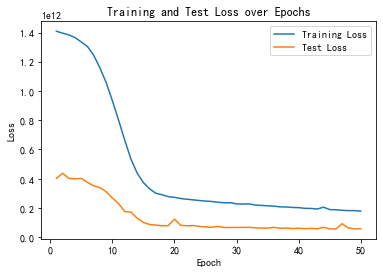

In [20]:
import matplotlib.pyplot as plt

num_epoch = 50
train_losses = []
test_losses = []

for i in range(num_epoch):
    print(f"==== Epoch {i} ====")
    train_loss = train_model(model, train_dataloader)
    test_loss = test_model(model, test_dataloader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)



plt.plot(range(1, num_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epoch + 1), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.show